In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw' #'inception' #wingbeatraw
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500)]#, RandomRoll() ,RandomFlip()]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]


In [4]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

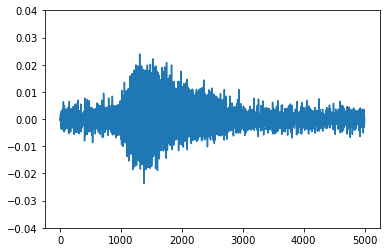

In [5]:
plot_wingbeat(train_dataset, idx=2)

In [6]:
outs = 2
if modeltype == 'wingbeatraw':
    model = DrosophilaNetRAW(outputs=outs, dropout_p=.2)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=outs))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
            loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
            val_loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best)


Training..	:   0%|          | 0/812 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 94.25it/s] 


Epoch 0: train_acc: 90.7% loss: 0.1087237,  val_loss: 0.7149413 val_acc: 90.4%
Validation accuracy improved from 0.00 to 90.44. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 96.10it/s] 


Epoch 1: train_acc: 94.5% loss: 0.0203215,  val_loss: 0.1181628 val_acc: 95.2%
Validation accuracy improved from 90.44 to 95.23. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 96.30it/s] 


Epoch 2: train_acc: 96.2% loss: 0.0066537,  val_loss: 0.0027940 val_acc: 94.7%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.19it/s] 


Epoch 3: train_acc: 97.3% loss: 0.3308905,  val_loss: 0.2698811 val_acc: 96.5%
Validation accuracy improved from 95.23 to 96.47. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.58it/s] 


Epoch 4: train_acc: 98.0% loss: 1.0095578,  val_loss: 0.0055974 val_acc: 96.4%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.62it/s] 


Epoch 5: train_acc: 98.3% loss: 0.0301328,  val_loss: 0.3797486 val_acc: 94.4%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.04it/s] 


Epoch 6: train_acc: 98.8% loss: 0.1446030,  val_loss: 0.1934845 val_acc: 96.1%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.21it/s] 


Epoch 7: train_acc: 98.9% loss: 0.0268344,  val_loss: 0.0009481 val_acc: 96.9%
Validation accuracy improved from 96.47 to 96.91. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.05it/s] 


Epoch 8: train_acc: 98.9% loss: 0.0790491,  val_loss: 0.1564676 val_acc: 94.6%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.29it/s] 


Epoch 9: train_acc: 99.1% loss: 0.0099340,  val_loss: 0.0339955 val_acc: 96.3%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 91.05it/s] 


Epoch 10: train_acc: 99.2% loss: 0.0014317,  val_loss: 0.0124670 val_acc: 95.1%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 96.04it/s] 


Epoch 11: train_acc: 99.2% loss: 0.0011932,  val_loss: 0.1323049 val_acc: 95.2%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 94.91it/s] 


Epoch 12: train_acc: 99.3% loss: 0.0460490,  val_loss: 0.1936891 val_acc: 96.3%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.29it/s] 


Epoch 13: train_acc: 99.2% loss: 0.0045894,  val_loss: 1.1327122 val_acc: 86.7%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 92.34it/s] 


Epoch 14: train_acc: 99.2% loss: 0.0002716,  val_loss: 0.0002950 val_acc: 96.8%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.42it/s] 


Epoch 15: train_acc: 99.4% loss: 0.0968285,  val_loss: 0.0007223 val_acc: 96.5%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.20it/s] 


Epoch 16: train_acc: 99.4% loss: 0.0064625,  val_loss: 0.0000006 val_acc: 96.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.61it/s] 


Epoch 17: train_acc: 99.3% loss: 0.0317113,  val_loss: 0.0000462 val_acc: 96.5%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.07it/s] 


Epoch 18: train_acc: 99.4% loss: 0.0003821,  val_loss: 0.0001013 val_acc: 96.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.43it/s] 


Epoch 19: train_acc: 99.5% loss: 0.0449318,  val_loss: 0.0484877 val_acc: 96.6%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.48it/s] 


Epoch 20: train_acc: 99.4% loss: 0.0004441,  val_loss: 0.0019226 val_acc: 96.3%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 94.87it/s] 


Epoch 21: train_acc: 99.5% loss: 0.0029614,  val_loss: 0.0050454 val_acc: 96.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.03it/s] 


Epoch 22: train_acc: 99.5% loss: 0.0255387,  val_loss: 0.0005396 val_acc: 96.3%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.76it/s] 


Epoch 23: train_acc: 99.4% loss: 0.0013544,  val_loss: 0.0705603 val_acc: 96.2%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.44it/s] 


Epoch 24: train_acc: 99.5% loss: 0.0991360,  val_loss: 0.1550696 val_acc: 96.8%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.15it/s] 


Epoch 25: train_acc: 99.4% loss: 0.0012906,  val_loss: 0.3620465 val_acc: 96.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.64it/s] 


Epoch 26: train_acc: 99.6% loss: 0.0703400,  val_loss: 0.0041615 val_acc: 96.2%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 93.30it/s] 


Epoch 27: train_acc: 99.4% loss: 0.0023927,  val_loss: 0.9663602 val_acc: 97.1%
Validation accuracy improved from 96.91 to 97.14. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.41it/s] 


Epoch 28: train_acc: 99.5% loss: 0.0040059,  val_loss: 0.1483242 val_acc: 96.8%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 93.34it/s] 


Epoch 29: train_acc: 99.7% loss: 0.0010664,  val_loss: 0.2745537 val_acc: 96.1%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.27it/s] 


Epoch 30: train_acc: 99.6% loss: 0.0054008,  val_loss: 0.0024651 val_acc: 96.8%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 96.16it/s] 


Epoch 31: train_acc: 99.4% loss: 0.0001392,  val_loss: 1.5536767 val_acc: 95.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 93.92it/s] 


Epoch 32: train_acc: 99.6% loss: 0.0840995,  val_loss: 0.2690073 val_acc: 95.6%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 93.69it/s] 


Epoch 33: train_acc: 99.6% loss: 0.0000147,  val_loss: 0.0102360 val_acc: 97.3%
Validation accuracy improved from 97.14 to 97.29. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.69it/s] 


Epoch 34: train_acc: 99.7% loss: 0.1924991,  val_loss: 0.4511975 val_acc: 96.9%


# MORE LAYERS?

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_best_time_signals.pth.tar', model, optimizer)

In [9]:
model = model.to('cuda', dtype=torch.float)

_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 803/803 [00:07<00:00, 112.85it/s]


Accuracy: 90.33
Balanced accuracy: 89.85
Confusion matrix: 
[[0.81460999 0.18539001]
 [0.01755162 0.98244838]]


## Testing on extra mebios data

In [10]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [11]:
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 711/711 [00:06<00:00, 112.00it/s]

Accuracy: 95.52
Balanced accuracy: 91.10
Confusion matrix: 
[[0.86177474 0.13822526]
 [0.03972742 0.96027258]]


In [12]:
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [13]:
from utils import get_all_preds

In [14]:
df_out = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=2)

100%|██████████| 803/803 [00:06<00:00, 117.31it/s]


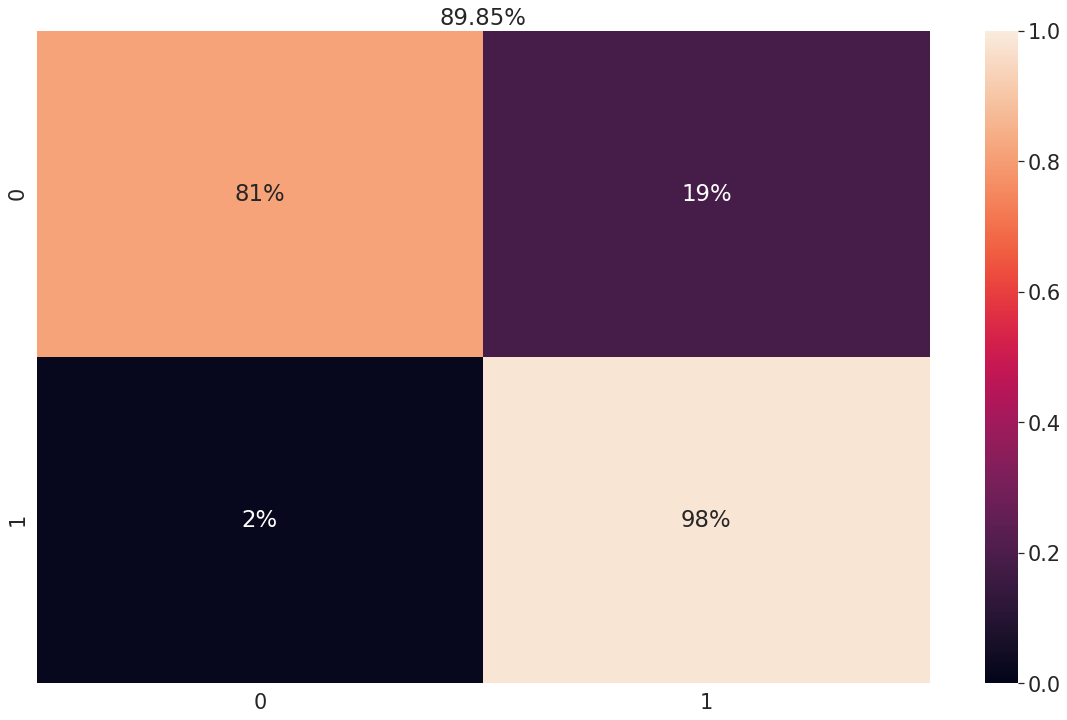

In [15]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatmain.eps", format='eps', bbox_inches='tight');

In [16]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm

array([[ 9869,  2246],
       [  238, 13322]])

# ------------------------------------------

In [17]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')

In [18]:
m = extra_df[extra_df.y==0].sample(1000)
s = extra_df[extra_df.y==1].sample(1000)
extra_df = pd.concat([m,s]).reset_index(drop=True)

In [19]:
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [20]:
df_out = get_all_preds(model, extra_dataloader, dataframe=True, final_nodes=2)

100%|██████████| 63/63 [00:00<00:00, 74.39it/s] 


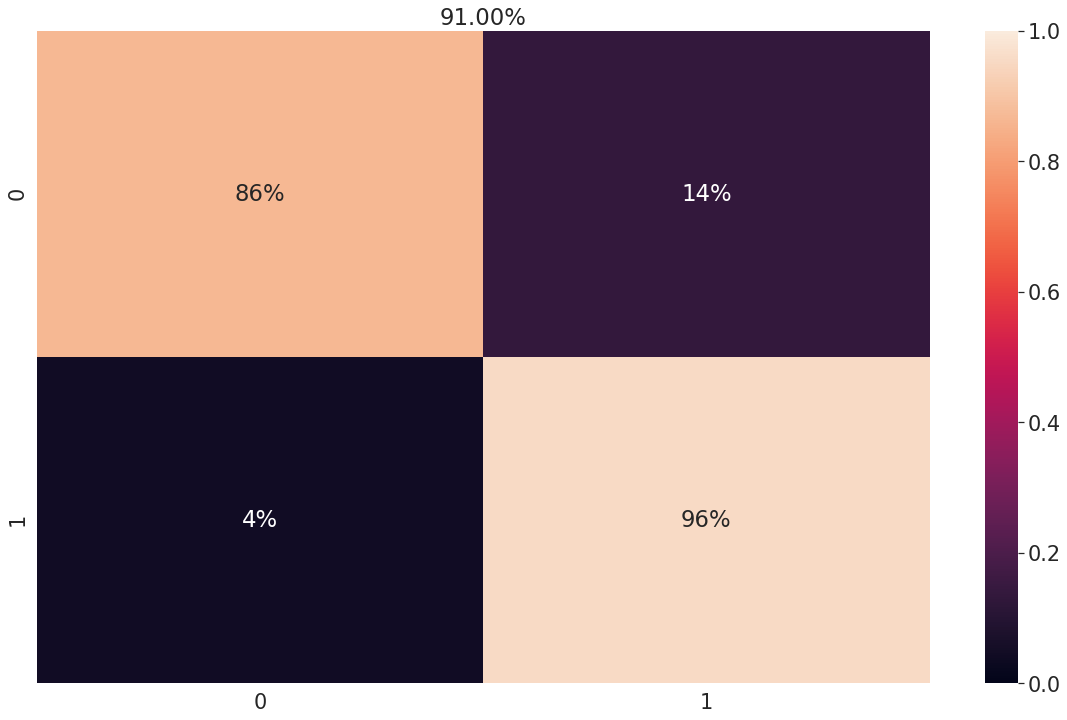

In [21]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatsecondary.eps", format='eps', bbox_inches='tight');

In [22]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm

array([[865, 135],
       [ 45, 955]])